In [115]:
from scipy.optimize import least_squares, minimize
import numpy as np
import matplotlib.pyplot as plt
from toy_datasets import ToyDatasets
from scipy.stats import norm

In [116]:
class Stage4Algorithm():
  def __init__(self, num_elements, h_order, ar_order):
    self.num_elements = num_elements
    self.h_order, self.ar_order = h_order, ar_order
    self.X, self.G, self.K = None, None, None
    self.dims = None

  def hankelise(self, x, order):
    hankel_matrix = np.zeros((order, x.shape[1] - order + 1))
    for i in range(order):
      hankel_matrix[i, :] = x[0, i:i+x.shape[1]-order+1]
    return hankel_matrix

  def objective(self, params):
    (X_shape, X_len), (G_shape, G_len), (K_shape, K_len) = self.dims
    X, G = params[:X_len], params[X_len:(X_len+G_len)]
    X, G = X.reshape(X_shape), G.reshape(G_shape)
    result = 0.5 * (np.linalg.norm(G, 'fro') ** 2)
    return result.flatten()

  def hankel_constraint(self, params):
    (X_shape, X_len), (G_shape, G_len), (K_shape, K_len) = self.dims
    X, K = params[:X_len], params[(X_len+G_len):]
    X, K = X.reshape(X_shape), K.reshape(K_shape)
    X1, X2 = X[:, :-1], X[:, 1:]
    X1, X2 = self.hankelise(X1, self.ar_order), self.hankelise(X2, self.ar_order)
    return (X2 - K @ X1).flatten()

  def D_constraint(self, params, D):
    (X_shape, X_len), (G_shape, G_len), (K_shape, K_len) = self.dims
    X, G = params[:X_len], params[X_len:(X_len+G_len)]
    X, G = X.reshape(X_shape), G.reshape(G_shape)
    return (D - X - G).flatten()
    
  def fit(self, D):
    X_initial_guess, G_initial_guess, K_initial_guess = \
      D, np.zeros(D.shape), np.zeros((self.ar_order, self.ar_order))
    for i in range(self.ar_order-1):
      K_initial_guess[i, i+1] = 1
    params = np.concatenate([X_initial_guess.flatten(), G_initial_guess.flatten(), K_initial_guess.flatten()])
    dims = (
      (X_initial_guess.shape, len(X_initial_guess.flatten())),
      (G_initial_guess.shape, len(G_initial_guess.flatten())),
      (K_initial_guess.shape, len(K_initial_guess.flatten()))
    )
    self.dims = dims
    constraints = (
      {'type': 'eq', 'fun': self.hankel_constraint},
      {'type': 'eq', 'fun': self.D_constraint, 'args': (D,)},
    )
    result = minimize(self.objective, params, constraints=constraints, method='trust-constr')
    (X_shape, X_len), (G_shape, G_len), (K_shape, K_len) = self.dims
    X, G, K = result.x[:X_len], result.x[X_len:(X_len+G_len)], result.x[(X_len+G_len):]
    X, G, K = X.reshape(X_shape), G.reshape(G_shape), K.reshape(K_shape)[-1]
    self.X, self.G, self.K = X, G, K

  def predict(self, x):
    y_predicted = []
    for i in range(x.shape[1] - self.ar_order):
      y_predicted.append(np.dot(x.flatten()[i:i+self.ar_order], self.K).flatten()[0])
    return y_predicted

  def forecast(self, x, timesteps):
    current_window = x[:, -self.ar_order:]
    forecasted = []
    for i in range(timesteps):
      next_el = np.dot(current_window.flatten(), self.K).flatten()[0]
      forecasted.append(next_el)
      current_window = np.append(current_window, next_el)[1:]
    return forecasted
  
  def evaluate(self, y, y_predicted):
    return np.sqrt(1/len(y) * np.sum(np.square(y - y_predicted)))

In [100]:
num_elements = 200
toy_datasets = ToyDatasets(num_elements=num_elements)

c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:80: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:203: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


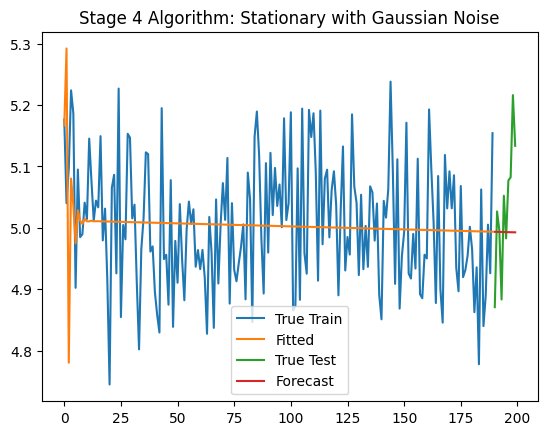

RMSE:  0.34188847778253134


In [108]:
np.random.seed(0)
order = 3
test_len = 10
toy_data = toy_datasets.stationary_with_gaussian_noise().reshape(-1, 1).T
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
plt.plot(range(train_data.shape[1]), fitted.flatten(), label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted, label="Forecast")
plt.title("Stage 4 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

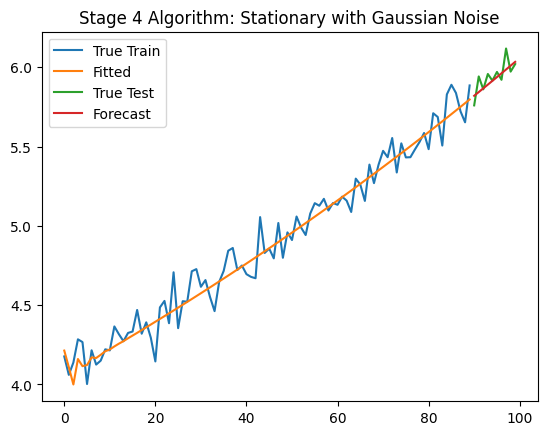

RMSE:  0.19957793553491787


In [112]:
num_elements = 100
toy_datasets = ToyDatasets(num_elements=num_elements)
np.random.seed(0)
order = 3
test_len = 10
toy_data = toy_datasets.linear_trending_with_gaussian_noise().reshape(-1, 1).T
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
plt.plot(range(train_data.shape[1]), fitted.flatten(), label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted, label="Forecast")
plt.title("Stage 4 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:80: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_differentiable_functions.py:504: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
c:\Users\chris\fyp\venv\lib\site-packages\scipy\optimize\_trustregion_constr\equality_constrained_sqp.py:203: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  Z, LS, Y = projections(A, factorization_method)


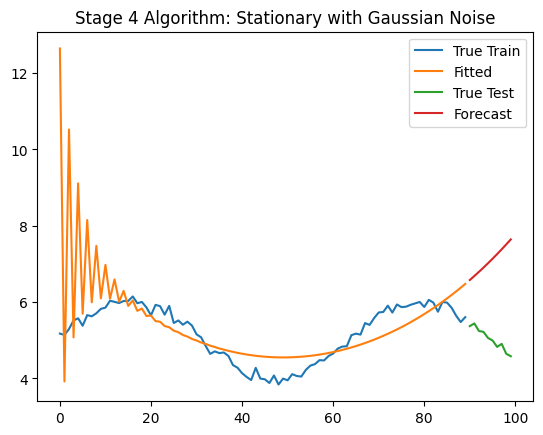

RMSE:  6.805653527405295


In [113]:
num_elements = 100
toy_datasets = ToyDatasets(num_elements=num_elements)
np.random.seed(0)
order = 3
test_len = 10
toy_data = toy_datasets.periodical_sinusoidal_with_gaussian_noise().reshape(-1, 1).T
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
plt.plot(range(train_data.shape[1]), fitted.flatten(), label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted, label="Forecast")
plt.title("Stage 4 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

In [118]:
num_elements = 30
toy_datasets = ToyDatasets(num_elements=num_elements)
np.random.seed(0)
order = 10
test_len = 10
toy_data = toy_datasets.periodical_sinusoidal_with_gaussian_noise().reshape(-1, 1).T
train_data, test_data = toy_data[:, :toy_data.shape[1]-test_len], toy_data[:, toy_data.shape[1]-test_len:]
alg = Stage4Algorithm(num_elements=num_elements, h_order=20, ar_order=order)
alg.fit(train_data)
fitted = alg.X
forecasted = alg.forecast(fitted, test_len)
plt.plot(range(train_data.shape[1]), train_data.flatten(), label="True Train")
plt.plot(range(train_data.shape[1]), fitted.flatten(), label="Fitted")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), test_data.flatten(), label="True Test")
plt.plot(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]), forecasted, label="Forecast")
plt.title("Stage 4 Algorithm: Stationary with Gaussian Noise")
plt.legend()
plt.show()
accuracy = alg.evaluate(test_data, forecasted)
print("RMSE: ", accuracy)

KeyboardInterrupt: 